In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from scipy import stats
import matplotlib
import matplotlib.animation as animation
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import glob
import pickle
import matplotlib.path as mpath
import warnings
warnings.filterwarnings("ignore")

In [35]:
def Prep():
    global deg2rad, Re, cp, rho, g, mylat, mylon, mylev, myilev, hyai, hybi,\
    landfrac, nlat, nlon, nlev, dlev, dmass, coslat, gw, dlat, dA, dA_big
    datadir = "/net/aeolus/aura/hansingh/SOMClimos/"
    myfile = "SOM_Control.cam5.0030-0059.ann.nc"
    deg2rad = np.pi/180.
    Re = 6.4e6
    cp = 3850.
    rho = 1000. #kg/m^3, for water
    g = 9.8
    myData_C = xr.open_dataset(datadir+myfile, decode_times=False)
    mylat = np.array(myData_C.lat)
    mylon = np.array(myData_C.lon)
    mylev = np.array(myData_C.lev)
    myilev = np.array(myData_C.ilev)
    hyai = np.array(myData_C.hyai)
    hybi = np.array(myData_C.hybi)
    landfrac = np.array(myData_C.LANDFRAC[0,:,:])
    nlat = len(mylat)
    nlon = len(mylon)
    nlev = len(mylev)
    dlev = np.zeros([nlev])
    for i in range(0,nlev):
        dlev[i] = myilev[i+1]-myilev[i]
    dmass = 100.*dlev/g #mass of air in each pressure level per m^2
    coslat = np.cos(deg2rad*mylat)
    gw = np.array(myData_C.gw)
    dlat = deg2rad*(mylat[1]-mylat[0])
    dA = (2.*np.pi*coslat*dlat*(Re**2))/nlon
    dA_big = np.zeros([nlat, nlon])
    for i in range(0,nlon):
        dA_big[:,i] = dA
        
#Mapping functions (lots)
def RobinsonMapFig(ax, myLat, myLon, myField, myConts, myCmap, myTitle):
    ax.coastlines()
    ax.gridlines()
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    mycontourf = ax.contourf(lon_cyc, myLat, data_cyc, myConts, transform=ccrs.PlateCarree(), cmap=myCmap)
    #plt.colorbar(mycontourf)
    return mycontourf
    
def StereoMapFig(myFig, xp, yp, ip, LatEdge, myLat, myLon, myField, myConts, myCmap):
    if LatEdge>0.:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.NorthPolarStereo())
    else:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if LatEdge>0.:
        ax.set_extent([-180, 180, LatEdge, 90], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, -90, LatEdge], ccrs.PlateCarree())
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    mycontour1 = ax.contourf(lon_cyc, myLat, data_cyc, myConts, transform=ccrs.PlateCarree(), cmap=myCmap, extend="both")
    return ax, mycontour1

def StereoMapFig2(myFig, xp, yp, ip, LatEdge, myLat, myLon, myField, myConts, myField2, myConts2, myCmap, mycolor):
    if LatEdge>0.:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.NorthPolarStereo())
    else:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if LatEdge>0.:
        ax.set_extent([-180, 180, LatEdge, 90], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, -90, LatEdge], ccrs.PlateCarree())
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    data_cyc2, lon_cyc = add_cyclic_point(myField2, coord=myLon)
    mycontour1 = ax.contourf(lon_cyc, myLat, data_cyc, myConts, transform=ccrs.PlateCarree(), cmap=myCmap, extend="both")
    mycontour2 = ax.contour(lon_cyc, myLat, data_cyc2, myConts2, transform=ccrs.PlateCarree(), colors=mycolor, linewidths=1.)
    return ax, mycontour1, mycontour2

def StereoMapFigLog(myFig, xp, yp, ip, LatEdge, myLat, myLon, myField, myConts, myCmap):
    if LatEdge>0.:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.NorthPolarStereo())
    else:
        ax = myFig.add_subplot(xp, yp, ip, projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.gridlines()
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if LatEdge>0.:
        ax.set_extent([-180, 180, LatEdge, 90], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, -90, LatEdge], ccrs.PlateCarree())
    data_cyc, lon_cyc = add_cyclic_point(myField, coord=myLon)
    print(data_cyc.min())
    print(data_cyc.max())
    mycontour1 = ax.pcolormesh(lon_cyc, myLat, data_cyc, transform=ccrs.PlateCarree(), cmap=myCmap, \
                             norm=matplotlib.colors.LogNorm(vmin=data_cyc.min(), vmax=1.))#, norm=matplotlib.colors.LogNorm())
    return ax, mycontour1

def FindFiles(myDir, myYr):
    mymonths = ["05", "06", "07", "08", "09"]
    nmonths = len(mymonths)
    myFiles = []
    for i in range(0,nmonths):
        myFiles += glob.glob(myDir+'/*'+myYr+"-"+mymonths[i]+'*.nc')
    return myFiles
    
def ConstructRI(RegionName):
    global RI
    RI = np.zeros([nlat, nlon])
    mylonbig, mylatbig = np.meshgrid(mylon, mylat)
    if RegionName=="WholeAA":
        RI = np.where((np.expand_dims(mylat,axis=1)<=-60.)&(landfrac>=0.5), 1., RI)
    #Define Region of Interest (RI)
    if RegionName=="WAIS":
        RI = np.where((mylatbig<=-60.)&(landfrac>=0.5)&(mylonbig>=170.)&(mylonbig<325.), \
                      1., RI)
    if RegionName=="EAIS":
        RI = np.where(((mylatbig<=-60.)&(landfrac>=0.5))&((mylonbig<170.)|(mylonbig>=325.)), \
                      1., RI)
    print("RI mask constructed")
    
def CalculateVapor(MyFile, MyYear, MyMonth):
    global myData, dMass, ColIntVap, ColIntVapClimo, ColIntVapAnom, ntime
    myData = xr.open_dataset(MyFile, decode_times=False)
    #Calculate dmass array
    P0=1.e5
    SfcPres = np.array(myData['PS'])
    PresIntfc = np.expand_dims(SfcPres, axis=1)*np.expand_dims(hybi,axis=(0,2,3))+P0*np.expand_dims(hyai,axis=(0,2,3))
    dPres = np.zeros([np.shape(PresIntfc)[0], nlev,nlat,nlon])
    for i in range(0,nlev):
        dPres[:,i,:,:] = PresIntfc[:,i+1,:,:]-PresIntfc[:,i,:,:]
    dMass = dPres/g
    #Construct Column-Integrated Vapor (in m) from Total Vapor
    VapByLev = np.array(myData['H2OV'])
    ntime = np.shape(VapByLev)[0]
    ColIntVap = np.zeros([ntime, nlat, nlon])
    for i in range(0,ntime):
        ColIntVap[i,:,:] = np.sum(VapByLev[i,:,:,:]*dMass[i,:,:,:], axis=0)/rho
    myclimofile = "1850-iso-gridtags.cam."+MyMonth+".nc"
    myDataClimo = xr.open_dataset(myclimofile, decode_times=False)
    #Construct Climo & Anom Column-Integrated Vapor (in m) from Total Vapor
    SfcPresClimo = np.array(myDataClimo['PS'])[0,:,:]
    PresIntfcClimo = np.expand_dims(SfcPresClimo, axis=0)*np.expand_dims(hybi,axis=(1,2))+P0*np.expand_dims(hyai,axis=(1,2))
    dPresClimo = np.zeros([nlev,nlat,nlon])
    for i in range(0,nlev):
        dPresClimo[i,:,:] = PresIntfcClimo[i+1,:,:]-PresIntfcClimo[i,:,:]
    dMassClimo = dPresClimo/g
    VapByLevClimo = np.array(myDataClimo['H2OV'])[0,:,:,:]
    ColIntVapClimo = np.sum(VapByLevClimo*dMassClimo, axis=0)/rho
    ColIntVapAnom = np.expand_dims(ColIntVapClimo,axis=0)-ColIntVap
    print("Column-integrated vapor calculated")

def CalculateSource(MyFile,MyYear,MyMonth):
    global SourceByDayRI
    myData = xr.open_dataset(MyFile, decode_times=False)
    #Setup
    LatVapTagNames = ['LAT05SV', 'LAT15SV', 'LAT25SV', 'LAT35SV', 'LAT45SV', 'LAT55SV', 'LAT65SV', 'LAT75SV', 'LAT85SV']
    ntaglat = len(LatVapTagNames)
    mylat_tag = np.array([-5., -15., -25., -35., -45., -55., -65., -75., -85.])
    LonVapTagNames = ['LON05EV', 'LON15EV', 'LON25EV', 'LON35EV', 'LON45EV', 'LON55EV', 'LON65EV', 'LON75EV', 'LON85EV', 'LON95EV',\
                      'LON105EV', 'LON115EV', 'LON125EV', 'LON135EV', 'LON145EV', 'LON155EV', 'LON165EV', 'LON175EV', 'LON185EV', 'LON195EV',\
                      'LON205EV', 'LON215EV', 'LON225EV', 'LON235EV', 'LON245EV', 'LON255EV', 'LON265EV', 'LON275EV', 'LON285EV', 'LON295EV',\
                      'LON305EV', 'LON315EV', 'LON325EV', 'LON335EV', 'LON345EV', 'LON355EV']
    ntaglon = len(LonVapTagNames)
    mylon_tag = np.linspace(5.,355.,36)
    ColIntVapTag = np.zeros([ntime, ntaglat, ntaglon])
    for i in range(0,ntaglat):
        LatTag = np.array(myData[LatVapTagNames[i]])
        print("Working on "+LatVapTagNames[i])
        for j in range(0,ntaglon):
            LonTag = np.array(myData[LonVapTagNames[j]])
            #print("Working on "+LonVapTagNames[j])
            #Overlap = np.sum(LatTag*LonTag*dMass, axis=1)/np.sum(LatTag*LatTag*dMass, axis=1)
            Overlap = np.sqrt(LonTag*LatTag)
            ColIntVapIJ = np.sum(Overlap*dMass, axis=1)/rho
            #sum over RI
            ColIntVapTag[:,i,j] = np.sum(np.expand_dims(RI*dA_big, axis=0)*ColIntVapIJ,axis=(1,2))/np.sum((RI*dA_big))        
    mylonbig, mylatbig = np.meshgrid(mylon, mylat)
    SourceByDayRI = np.zeros([ntime, nlat, nlon])
    for itime in range(0,ntime):
        for i in range(0,ntaglat):
            for j in range(0,ntaglon):
                SourceByDayRI[itime,:,:] = np.where((np.abs(mylonbig-mylon_tag[j])<=5.)&(np.abs(mylatbig-mylat_tag[i])<=5.),\
                                                    ColIntVapTag[itime,i,j], SourceByDayRI[itime,:,:])
    pickle.dump(SourceByDayRI, open("SourceByDayRI_"+MyYear+"_"+MyMonth+"_"+myregion+".pkl", "wb"))
    
def CalculateTemp(MyFile,MyMonth):
    global TS, TSClimo, TSAnom
    myData = xr.open_dataset(MyFile, decode_times=False)
    myclimofile = "1850-iso-gridtags.cam."+MyMonth+".nc"
    myDataClimo = xr.open_dataset(myclimofile, decode_times=False)
    TS = myData['T'][:,nlev-1,:,:]
    TSClimo = myDataClimo['T'][0,nlev-1,:,:]
    TSAnom = TS-TSClimo

In [59]:
mydir = "/net/aeolus/aura/kheyblom/iCESM-output/1850-iso-gridtags/cam/day/"
myyr = "0009"
months = ["05", "06", "07", "08", "09"]
myregion = "WAIS" #WAIS, EAIS, WholeAA

#Run the analysis
Prep()
myfiles = FindFiles(mydir,myyr)
ConstructRI(myregion)

for i in range(0,len(months)):
    myMonth=months[i]
    CalculateTemp(myfiles[i], myMonth)
    CalculateVapor(myfiles[i], myyr, myMonth)
    CalculateSource(myfiles[i], myyr, myMonth)
    if i==0:
        myColIntVap=ColIntVap
        myColIntVapAnom=ColIntVapAnom
        myColIntVapClimo=np.expand_dims(ColIntVapClimo,axis=0)
        mySourceByDayRI = SourceByDayRI
        myTS = TS
        myTSClimo = np.expand_dims(TSClimo,axis=0)
        myTSAnom = TSAnom
    else:
        myColIntVap = np.concatenate((myColIntVap,ColIntVap),axis=0)
        myColIntVapAnom = np.concatenate((myColIntVapAnom,ColIntVapAnom),axis=0)
        myColIntVapClimo = np.concatenate((myColIntVapClimo,np.expand_dims(ColIntVapClimo,axis=0)),axis=0)
        mySourceByDayRI = np.concatenate((mySourceByDayRI,SourceByDayRI),axis=0)
        myTS = np.concatenate((myTS,TS),axis=0)
        myTSClimo = np.concatenate((myTSClimo,np.expand_dims(TSClimo,axis=0)),axis=0)
        myTSAnom = np.concatenate((myTSAnom,TSAnom),axis=0)

RI mask constructed
Column-integrated vapor calculated
Working on LAT05SV
Working on LAT15SV
Working on LAT25SV
Working on LAT35SV
Working on LAT45SV
Working on LAT55SV
Working on LAT65SV
Working on LAT75SV
Working on LAT85SV
Column-integrated vapor calculated
Working on LAT05SV
Working on LAT15SV
Working on LAT25SV
Working on LAT35SV
Working on LAT45SV
Working on LAT55SV
Working on LAT65SV
Working on LAT75SV
Working on LAT85SV
Column-integrated vapor calculated
Working on LAT05SV
Working on LAT15SV
Working on LAT25SV
Working on LAT35SV
Working on LAT45SV
Working on LAT55SV
Working on LAT65SV
Working on LAT75SV
Working on LAT85SV
Column-integrated vapor calculated
Working on LAT05SV
Working on LAT15SV
Working on LAT25SV
Working on LAT35SV
Working on LAT45SV
Working on LAT55SV
Working on LAT65SV
Working on LAT75SV
Working on LAT85SV
Column-integrated vapor calculated
Working on LAT05SV
Working on LAT15SV
Working on LAT25SV
Working on LAT35SV
Working on LAT45SV
Working on LAT55SV
Working

In [57]:
print(np.max(mySourceByDayRI))

0.0005702135699603943


0.011628853478448973
6.2973732047783155


MovieWriter Pillow unavailable; using Pillow instead.


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


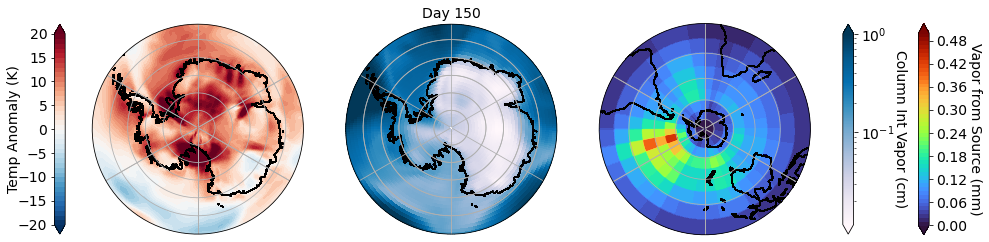

In [60]:
myfig = plt.figure(figsize=[15,13])
myconts_Source = np.linspace(0.,0.5,51)
myconts_WV2 = np.linspace(0., 1., 21)
myconts_tas = np.linspace(-20.,20.,41)

#Individual Panels
myax1, c = StereoMapFig(myfig, 1,3, 1, -60, mylat, mylon, myTSAnom[0,:,:], myconts_tas, "RdBu_r")
myax0, c10 = StereoMapFigLog(myfig, 1,3, 2, -60, mylat, mylon, myColIntVap[0,:,:]*100., myconts_WV2, "PuBu")
myax0.set_title("Day "+str(i+1), fontsize=14)
myax, c1 = StereoMapFig(myfig, 1,3, 3, -1., mylat, mylon, mySourceByDayRI[0,:,:]*1000., myconts_Source, "turbo")
plt.subplots_adjust(left=0.135, bottom=0.1, right=0.8, top=0.9)

#Colorbars
bbox_ax1 = myax1.get_position()
# fig.add_axes() adds the colorbar axes
# they're bounded by [x0, y0, x_width, y_width]
cbar_im1a_ax1 = myfig.add_axes([0.1, bbox_ax1.y0, 0.01, (bbox_ax1.y1-bbox_ax1.y0)])
cbar_im1a1 = plt.colorbar(c, cax=cbar_im1a_ax1, extend='both')
cbar_im1a1.ax.tick_params(labelsize=14)
cbar_im1a_ax1.yaxis.set_ticks_position('left')
cbar_im1a1.ax.set_ylabel("Temp Anomaly (K)", rotation=90, fontsize=14, labelpad=-58.)

bbox_ax0 = myax0.get_position()
cbar_im1a_ax0 = myfig.add_axes([0.83, bbox_ax0.y0, 0.01, (bbox_ax0.y1-bbox_ax0.y0)])
cbar_im1a0 = plt.colorbar(c10, cax=cbar_im1a_ax0, extend='both')
cbar_im1a0.ax.tick_params(labelsize=14)
cbar_im1a0.ax.set_ylabel("Column Int Vapor (cm)", rotation=270, fontsize=14, labelpad=13.)

bbox_ax = myax.get_position()
cbar_im1a_ax = myfig.add_axes([0.9, bbox_ax.y0, 0.01, (bbox_ax.y1-bbox_ax.y0)])
cbar_im1a = plt.colorbar(c1, cax=cbar_im1a_ax, extend='both')
cbar_im1a.ax.tick_params(labelsize=14)
cbar_im1a.ax.set_ylabel("Vapor from Source (mm)", rotation=270, fontsize=14, labelpad=15.)

#Animation
def animate(i):
    global myax1, myax0, myax
    data_cyc, lon_cyc = add_cyclic_point(myTSAnom[i,:,:], coord=mylon)
    for c in myax1.collections:
        c.remove()
    myax1.coastlines()
    myax1.gridlines()
    myax1.contourf(lon_cyc, mylat, data_cyc, myconts_tas, transform=ccrs.PlateCarree(), \
                  cmap="RdBu_r", extend="both")
    data_cyc, lon_cyc = add_cyclic_point(myColIntVap[i,:,:]*100., coord=mylon)
    for c in myax0.collections:
        c.remove() #remove old data from the figure
    myax0.coastlines()
    myax0.gridlines()
    print(i)
    myax0.pcolormesh(lon_cyc, mylat, data_cyc, transform=ccrs.PlateCarree(), cmap="PuBu", \
                   norm=matplotlib.colors.LogNorm(vmin=data_cyc.min(), vmax=1.))#, norm=matplotlib.colors.LogNorm())  # update the data.
    myax0.set_title("Day "+str(i+1), fontsize=14)
    data_cyc, lon_cyc = add_cyclic_point(mySourceByDayRI[i,:,:]*1000., coord=mylon)
    for c in myax.collections:
        c.remove()
    myax.coastlines()
    myax.gridlines()
    myax.contourf(lon_cyc, mylat, data_cyc, myconts_Source, transform=ccrs.PlateCarree(), \
                  cmap="turbo", extend="both")
    return myax1, myax0, myax

ani = animation.FuncAnimation(myfig, animate, frames=150, repeat=False)
ani.save('AntarcticSource_MJJAS_yr'+myyr+'_'+myregion+'_032022.gif', writer='Pillow', fps=1)